#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/opt/anaconda3/envs/csma3/bin/python


# Install dependencies:

In [2]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/csma3

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         121 KB
    openssl-1.1.1h             |       haf1e3a3_0         2.2 MB
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following packages will be UPDATED:

  certifi                anaconda::certifi-2020.6.20-py36_0 --> pkgs/main::certifi-2020.11.8-py36hecd8cb5_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  openssl                                          anaconda --> pkgs/main



ca-certificates-2020 | 121 KB    | ##################################### | 10

# Imports

In [8]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [17]:
data_path = './data/videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [10]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [11]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [12]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [13]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 25914/25914 [00:03<00:00, 8283.88it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [14]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the earth will also change because of the weight diffrence at both poles ? And would this affect the land mass to change also?,0,If all the ice melts surely the tilt of the earth will also change because of\nthe weight diffrence at both poles ? And would this affect the land mass to\nchange also?\n\n
1,2020-01-16 06:16:07,Aakash Majumdar,The scariest part of the video is the music..... How dramatic the music is...,0,The scariest part of the video is the music..... How dramatic the music is...\n\n
2,2020-01-15 10:50:21,Glenn Davies,New Zealand be like...&quot;are we good?&quot; 🤷‍♂️,0,"New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Utopia,0,Step #1: Taxes... Step #2: ???... Step #3: Utopia\n\n
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson&#39;s Bay stayed the same size.,0,Strange how Hudson's Bay stayed the same size.\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [19]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [20]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 The embeddings vector is of fixed length 512


TensorShape([25914, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 9.9999994e-01 -2.3349244e-03  1.4289129e-01 ... -3.6314797e-02
   1.9422036e-01  2.9228735e-01]
 [-2.3349244e-03  1.0000001e+00  2.0237446e-02 ...  4.6902239e-01
   7.3805079e-02 -8.1712566e-04]
 [ 1.4289129e-01  2.0237446e-02  1.0000000e+00 ...  9.5560461e-02
   1.6631317e-01  2.7421292e-02]
 ...
 [-3.6314797e-02  4.6902239e-01  9.5560461e-02 ...  9.9999994e-01
   2.0505231e-02 -5.3927824e-03]
 [ 1.9422036e-01  7.3805079e-02  1.6631317e-01 ...  2.0505231e-02
   9.9999988e-01  3.0619627e-01]
 [ 2.9228735e-01 -8.1712566e-04  2.7421292e-02 ... -5.3927824e-03
   3.0619627e-01  1.0000000e+00]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

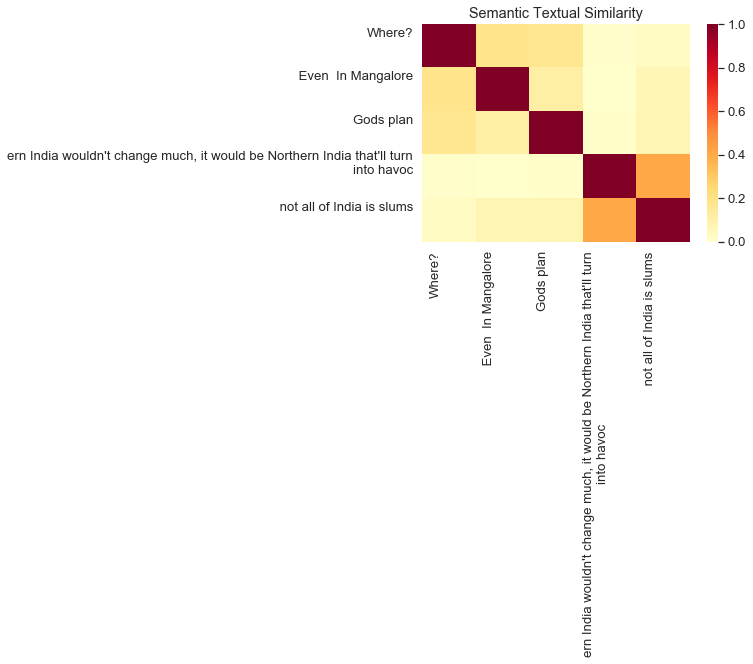

In [22]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [23]:
comment_index = 324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Not as bad as I thought it would be




Print similar comments.

In [24]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Not as bad as I thought it would be


Top similar comment 2: Heh, not as bad as I thought it would be


Top similar comment 3: It's not as bad as I thought it would be.


Top similar comment 4: Well it's not as bad as I thought it would be


Top similar comment 5: Not as bad as I expected. Let it melt


Top similar comment 6: Not as bad as I thought tbh


Top similar comment 7: That's not nearly as bad as I thought it would be.


Top similar comment 8: Not as bad as I thought 🤷‍♂️


Top similar comment 9: thats actually not as bad as i thought it would be


Top similar comment 10: not that bad as i imagined could be worse


Top similar comment 11: well that wasn't as bad as I thought it would be


Top similar comment 12: Not as bad as i thought, hardly notice :-)


Top similar comment 13: Honestly not as bad as I expected


Top similar comment 14: it does not look as bad as I thought it would be


Top similar comment 15: To be honest, Not too bad... I was expecti